### Imports

In [35]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
from pandas import to_datetime
import statsmodels.api as sm
from statsmodels import regression
from sklearn.linear_model import LinearRegression


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [36]:
buy_threshold = 1.1
sell_threshold = 1.1
starting_balance = 1000000
price_cap_lower = 1
investment_ratio = 0.00001

run_optimizing = False
google_colab = False

### Data loading

In [37]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "15eesIDv1QR3465iekfFG52v-HIYheguO"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('11.05 1 mnd test sett full model run_with_TTM0_Q1and2_2018_filtered_missing.csv')  
    df = pd.read_csv('11.05 1 mnd test sett full model run_with_TTM0_Q1and2_2018_filtered_missing.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/trading/Full trading data - All models.csv')

In [38]:
# Drop Expire_date column
df.drop('Expire_date', axis=1, inplace=True)

In [39]:
display(df)

,Quote_date,Price,Bid,Ask,Underlying_last,Strike,TTM,Delta,IV,R,Price_drop,Rolling,GARCH,BS-IV,Heston,LSTM-MLP,Expiry_date,Option_ID
0,2015-01-12,603.295,602.2,604.39,2028.56,1425.0,2.0,1.00000,0.00000,0.0002,603.295,6.035623e+02,6.035623e+02,6.435516e+02,605.290994,603.12946,2015-01-15,2015-01-15-1425.0
1,2015-01-12,483.900,482.4,485.40,2028.56,1545.0,2.0,0.99564,1.02531,0.0002,483.900,4.835625e+02,4.835625e+02,4.966703e+02,485.306680,483.69577,2015-01-15,2015-01-15-1545.0
2,2015-01-12,468.450,467.2,469.70,2028.56,1560.0,2.0,1.00000,0.00000,0.0002,468.450,4.685626e+02,4.685626e+02,4.832197e+02,467.614355,468.75870,2015-01-15,2015-01-15-1560.0
3,2015-01-12,363.550,362.4,364.70,2028.56,1665.0,2.0,1.00000,0.00000,0.0002,363.550,3.635627e+02,3.635627e+02,3.748025e+02,361.991271,364.29678,2015-01-15,2015-01-15-1665.0
4,2015-01-12,322.950,321.9,324.00,2028.56,1705.0,2.0,1.00000,0.00000,0.0002,322.950,3.235628e+02,3.235628e+02,3.301411e+02,323.068179,324.65866,2015-01-15,2015-01-15-1705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8759370,2023-03-30,595.250,593.7,596.80,4050.95,3455.0,0.0,1.00000,0.00000,0.0474,595.250,5.963986e+02,5.963986e+02,5.963986e+02,604.961845,607.60376,2023-03-31,2023-03-31-3455.0
8759371,2023-03-30,466.450,465.9,467.00,4050.95,3585.0,0.0,1.00000,-0.00027,0.0474,466.450,4.664155e+02,4.664155e+02,4.664155e+02,458.415914,474.68167,2023-03-31,2023-03-31-3585.0
8759372,2023-03-30,461.450,460.9,462.00,4050.95,3590.0,0.0,1.00000,-0.00025,0.0474,461.450,4.614162e+02,4.614162e+02,4.614162e+02,453.898531,469.61115,2023-03-31,2023-03-31-3590.0
8759373,2023-03-30,180.650,180.0,181.30,4050.95,3870.0,0.0,1.00000,0.00000,0.0474,180.650,1.814525e+02,1.814525e+02,1.814525e+02,183.942814,192.88177,2023-03-31,2023-03-31-3870.0


In [40]:
lstm_mlp = True
bs_rolling = False
bs_garch = False
bs_iv = False
heston = False

if lstm_mlp:
    # Out of Quote_date	Expire_date	Price	Bid	Ask	Underlying_last	Strike	TTM	Delta	IV	R	Price_drop	Rolling	GARCH	BS-IV	Heston	LSTM-MLP, drop Rolling, GARCH, BS-IV, Heston
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'LSTM-MLP']]
    # Rename LSTM-MLP to Prediction
    df = df.rename(columns={'LSTM-MLP': 'Prediction'})
elif bs_rolling:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Rolling']]
    df = df.rename(columns={'Rolling': 'Prediction'})
elif bs_garch:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'GARCH']]
    df = df.rename(columns={'GARCH': 'Prediction'})
elif bs_iv:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'BS-IV']]
    df = df.rename(columns={'BS-IV': 'Prediction'})
elif heston:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Heston']]
    df = df.rename(columns={'Heston': 'Prediction'})

### Data processing

In [41]:
df["TTM"] = (df["TTM"]*365).astype(int)

In [42]:
print(len(df))

8759375


# Trading functions

In [43]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] / df['Price']) >= buy_threshold
    sell_signal = (df['Price'] / df['Prediction']) >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio = 0.002):
    df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])
    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    df = df[df['Expiry_date'] <= df['Quote_date'].max()]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1

    df['Position_this_opt'] = 0
    df['Balance'] = -1000000    # Makes it easy to spot if balance has not been updated correctly

    df = df.sort_values('Quote_date')
    df['Option_ID'] = df['Option_ID'].astype(str)

    position_dict = {id:0 for id in df['Option_ID'].unique()}
    first_date = df['Quote_date'].min()
    total_balance_dict = {first_date: starting_balance}

    def operation(row):
        if row['Quote_date'] not in total_balance_dict.keys():
            total_balance_dict[row['Quote_date']] = total_balance_dict[max(total_balance_dict.keys())]

        balance = total_balance_dict[row['Quote_date']]
        position = position_dict[row['Option_ID']]

        if row["Price"] < price_cap_lower:
            row["Position_this_opt"] = position
            row["Balance"] = balance
            position_dict[row['Option_ID']] = position
            total_balance_dict[row['Quote_date']] = balance
            return row

        if row['Signal'] == 1 and row["Quote_date"] != row["Expiry_date"] and balance > 100:
            amount_to_invest = balance * investment_ratio
            if amount_to_invest <= balance:
                balance -= amount_to_invest * (1 + investment_ratio)
                position += amount_to_invest / row['Price']


        elif row['Signal'] == -1 and row["Quote_date"] != row["Expiry_date"] and balance > 100:
            amount_to_sell = balance * investment_ratio
            balance += amount_to_sell * (1 - investment_ratio)
            position -= amount_to_sell / row['Price']


        elif row["Quote_date"] == row["Expiry_date"] and position != 0:
            intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
            adjustment = intrinsic_value if position > 0 else -intrinsic_value
            balance += adjustment * abs(position)
            position = 0

        
        row['Position_this_opt'] = position
        position_dict[row['Option_ID']] = position
        total_balance_dict[row['Quote_date']] = balance
        row['Balance'] = balance

        # Print progress
        if row.name % 100000 == 0:
            print(row["Quote_date"])

        return row

    df = df.apply(operation, axis=1)
    df.loc[(df['Position_this_opt'] == 0), 'Balance'] = df['Quote_date'].map(total_balance_dict)

    return df

def calculate_options_value(df):
    df['Options_value'] = 0
    for date in df['Quote_date'].unique():
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df


### Analysis functions

In [44]:
def sharpe_ratio(df):
    df_group = df.groupby('Quote_date').last()
    df_group['Excess_Returns'] = df_group['Total_value'].pct_change() - 0.02 / 252
    sharpe_ratio = np.sqrt(252) * (df_group["Excess_Returns"].mean() / df_group["Excess_Returns"].std())
    return sharpe_ratio

In [45]:
def sharpe_ratio_monthly(df):
    df_sharpe = df.copy()

    # Get YYYY-MM for each row
    df_sharpe["YYYY-MM"] = df_sharpe["Quote_date"].dt.strftime("%Y-%m")
    df_sharpe = df_sharpe.groupby("YYYY-MM").last()
    df_sharpe["Excess_Returns"] = df_sharpe["Total_value"].pct_change() - 0.02 / 12
    sharpe_ratio = np.sqrt(12) * (df_sharpe["Excess_Returns"].mean() / df_sharpe["Excess_Returns"].std())
    return sharpe_ratio 

In [46]:
def capm_alpha(df_capm):
    # Find alpha in the CAPM model using linear regression and grouping df by Quote_date, then taking the alpha of Total_value compared to Underlying_last which is the S&P500
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']]
    df_capm = df_capm.dropna()
    df_capm['Underlying_last'] = df_capm['Underlying_last'].pct_change()
    df_capm['Total_value'] = df_capm['Total_value'].pct_change()
    df_capm = df_capm.dropna()
    df_capm = df_capm.reset_index()
    df_capm = df_capm.drop(columns=['Quote_date'])
    df_capm = df_capm.dropna()
    X = df_capm['Underlying_last'].values.reshape(-1, 1)
    y = df_capm['Total_value'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.intercept_[0] * 252

In [47]:
def capm_beta(df_capm):
    # Find beta in the CAPM model using linear regression and grouping df by Quote_date, then taking the beta of Total_value compared to Underlying_last which is the S&P500
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']]
    df_capm = df_capm.dropna()
    df_capm['Underlying_last'] = df_capm['Underlying_last'].pct_change()
    df_capm['Total_value'] = df_capm['Total_value'].pct_change()
    df_capm = df_capm.dropna()
    df_capm = df_capm.reset_index()
    df_capm = df_capm.drop(columns=['Quote_date'])
    df_capm = df_capm.dropna()
    X = df_capm['Underlying_last'].values.reshape(-1, 1)
    y = df_capm['Total_value'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.coef_[0][0] * 252

In [48]:
def max_drawdown(df):
    df_group = df.groupby('Quote_date').last()
    df_group['Roll_Max'] = df_group['Total_value'].cummax()
    df_group['Drawdown'] = df_group['Total_value'] / df_group['Roll_Max'] - 1.0
    df_group['Drawdown'].min()
    return df_group['Drawdown'].min() * 100

In [49]:
def print_results(df, starting_balance):
    ending_balance = df['Balance'].iloc[-1]
    profit = ending_balance - starting_balance
    num_trades = df[df["Price"] > 1]["Signal"].abs().sum()
    profit_per_trade = profit / num_trades

    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    trading_days = df['Quote_date'].unique().shape[0] - 1
    profit_per_day = profit / trading_days
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days

    annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

    print(f"Starting balance: {starting_balance}")
    print(f"Ending balance: {ending_balance.round(0)}")
    print(f"Profit: {profit.round(0)}")
    print(f"Profit per trade: {profit_per_trade.round(2)}")
    print(f"Profit per trading day: {profit_per_day.round(2)}")
    print(f"Sharpe ratio: {sharpe_ratio_monthly(df).round(2)}")
    print(f"CAPM alpha: {capm_alpha(df).round(2)}")
    print(f"Annualized return in percent: {annualized_return.round(2)}")
    print(f"Max drawdown: {max_drawdown(df).round(2)}")

In [50]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Cash')
    plt.plot(df['Options_value'], label='Net value of options')
    plt.title('Portfolio value over time')
    # Make plot smaller
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## Run the code

In [51]:
if run_optimizing == False:
    df = df.copy()
    buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
    df = trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio)
    df = calculate_options_value(df)
    print_results(df, starting_balance)

,Quote_date,Expiry_date,Price,Bid,Ask,Underlying_last,Strike,TTM,Delta,IV,R,Price_drop,Option_ID,Prediction
0,2015-01-12,2015-01-15,603.295,602.2,604.39,2028.56,1425.0,730,1.00000,0.00000,0.0002,603.295,2015-01-15-1425.0,603.12946
1,2015-01-12,2015-01-15,483.900,482.4,485.40,2028.56,1545.0,730,0.99564,1.02531,0.0002,483.900,2015-01-15-1545.0,483.69577
2,2015-01-12,2015-01-15,468.450,467.2,469.70,2028.56,1560.0,730,1.00000,0.00000,0.0002,468.450,2015-01-15-1560.0,468.75870
3,2015-01-12,2015-01-15,363.550,362.4,364.70,2028.56,1665.0,730,1.00000,0.00000,0.0002,363.550,2015-01-15-1665.0,364.29678
4,2015-01-12,2015-01-15,322.950,321.9,324.00,2028.56,1705.0,730,1.00000,0.00000,0.0002,322.950,2015-01-15-1705.0,324.65866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8759370,2023-03-30,2023-03-31,595.250,593.7,596.80,4050.95,3455.0,0,1.00000,0.00000,0.0474,595.250,2023-03-31-3455.0,607.60376
8759371,2023-03-30,2023-03-31,466.450,465.9,467.00,4050.95,3585.0,0,1.00000,-0.00027,0.0474,466.450,2023-03-31-3585.0,474.68167
8759372,2023-03-30,2023-03-31,461.450,460.9,462.00,4050.95,3590.0,0,1.00000,-0.00025,0.0474,461.450,2023-03-31-3590.0,469.61115
8759373,2023-03-30,2023-03-31,180.650,180.0,181.30,4050.95,3870.0,0,1.00000,0.00000,0.0474,180.650,2023-03-31-3870.0,192.88177


/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_2561/2262240980.py:12: RuntimeWarning: invalid value encountered in double_scalars
  annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100


Starting balance: 100000
Ending balance: -82120.0
Profit: -182120.0
Profit per trade: -0.1
Profit per trading day: -88.54
Sharpe ratio: -0.41
CAPM alpha: 0.77
Annualized return in percent: nan
Max drawdown: -292.63


### Post analysis

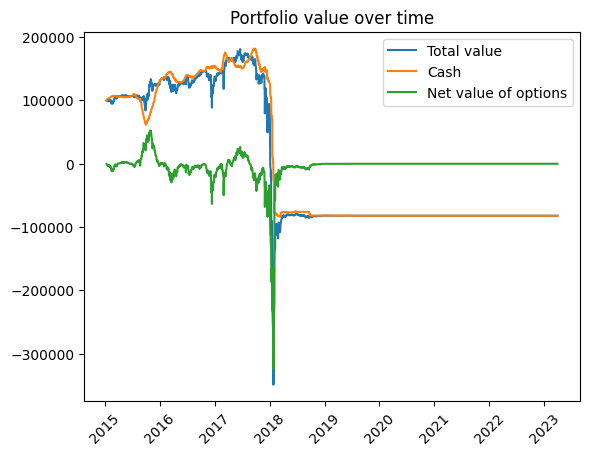

In [52]:
if run_optimizing == False:
    plot(df)

## Threshold search

In [53]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': '1H18 - v10 - test',
    'metric': {
        'goal': 'maximize', 
        'name': 'alpha'
        },
    'parameters': {
        'buy_threshold': {
            'values': [1.1, 1.06, 1.04, 1.02]},
        'sell_threshold': {
            'values': [1.1, 1.06, 1.04, 1.02]},
        'price_cap_lower': {
            'values': [1]},
        'investment_ratio': {
            'values': [0.000001]},
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


In [54]:
if run_optimizing:
    def find_best_thresholds(df = df):
        run = wandb.init(project = "options-trading")
        df = df.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, starting_balance=100000, price_cap_lower = run.config.price_cap_lower, investment_ratio = run.config.investment_ratio)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio(df), "ending_balance": df['Balance'].iloc[-1], "number_of_trades": df['Signal'].abs().sum(), "alpha": capm_alpha(df)})
        # Wandb callback
        print_results(df, 100000)
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)